Trabalho de Referência  
https://python.plainenglish.io/creating-machine-learning-models-to-predict-football-game-outcomes-70b6bf02885c  
https://github.com/RishiSankhe/FbMatchPredictor

Importando Pacotes

In [93]:
# !pip install -r requirements.txt

In [94]:
import pandas as pd
import numpy as np
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import  MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import KFold

Configurações do codigo

In [95]:
#Exibir totas as colunas no pandas
pd.set_option('display.max_columns', None)
season = 2023

import warnings 
warnings.filterwarnings("ignore")

### Importando a Base Tratada

In [96]:
data = pd.read_excel(f'data/trusted/base_brasileirao_{season}.xlsx')
data = data[data['league.round'] < 35]

data.head()

,fixture.id,fixture.date,league.round,teams.home.id,teams.home.name,teams.home.winner,teams.away.id,teams.away.name,teams.away.winner,score.halftime.home,score.halftime.away,score.fulltime.home,score.fulltime.away,result,result.team,HTR,home.pf.drw,home.pf.win,home.pf.los,away.pf.drw,away.pf.win,away.pf.los,home.BLPS,home.BSH,home.CK,home.EXPGL,home.FOU,home.GKSV,home.OFSD,home.PAS%,home.PASAC,home.RCD,home.SHFG,home.SHIN,home.SHOG,home.SHOU,home.TPAS,home.TSH,home.YCD,away.BLPS,away.BSH,away.CK,away.EXPGL,away.FOU,away.GKSV,away.OFSD,away.PAS%,away.PASAC,away.RCD,away.SHFG,away.SHIN,away.SHOG,away.SHOU,away.TPAS,away.TSH,away.YCD
0,1005649,2023-04-16,1,127,Flamengo,True,147,Coritiba,False,1,0,3,0,1,Flamengo,1,NaN,NaN,NaN,NaN,NaN,NaN,59,3,6,1.37,20,3,1,89,480,0,5,5,7,10,542,15,3,41,5,3,0.36,17,4,2,85,322,0,2,3,3,7,379,10,3
1,1005650,2023-04-15,1,120,Botafogo,True,126,Sao Paulo,False,1,1,2,1,1,Botafogo,0,NaN,NaN,NaN,NaN,NaN,NaN,32,4,3,0.84,20,7,2,78,229,0,5,6,3,6,293,12,3,68,2,7,1.86,13,1,1,89,574,0,6,11,8,5,646,16,2
2,1005651,2023-04-15,1,121,Palmeiras,True,1193,Cuiaba,False,1,1,2,1,1,Palmeiras,0,NaN,NaN,NaN,NaN,NaN,NaN,52,5,4,2.69,23,3,3,84,382,0,7,10,5,7,455,17,2,48,2,4,0.67,12,3,2,79,337,1,6,6,4,6,426,12,5
3,1005652,2023-04-16,1,131,Corinthians,True,135,Cruzeiro,False,0,0,2,1,1,Corinthians,0,NaN,NaN,NaN,NaN,NaN,NaN,42,1,7,1.54,14,1,4,78,316,0,4,6,7,6,406,12,4,58,3,4,0.49,12,5,3,85,489,0,3,4,2,4,572,8,2
4,1005653,2023-04-15,1,794,RB Bragantino,True,118,Bahia,False,0,1,2,1,1,RB Bragantino,-1,NaN,NaN,NaN,NaN,NaN,NaN,56,2,4,2.11,20,2,2,78,339,0,4,6,7,7,436,13,3,44,1,7,0.65,13,5,3,72,248,0,5,5,3,4,343,9,1


In [97]:
matches = data.shape[0]
columns = data.shape[1]

home_win = len(data[data['result'] == 1])
away_win = len(data[data['result'] == -1])
draw_win = len(data[data['result'] == 0])

print('Qtd Partidas:', matches)
print('Qtd Colunas:', columns)
print('Vit Mandante:', home_win)
print('Vit Visitante:', away_win)
print('Empate:', draw_win)
print('% Mandante:', round(home_win/matches*100,2))
print('% Visitante:', round(away_win/matches*100,2))
print('% Empate:', round(draw_win/matches*100,2))

Qtd Partidas: 340
Qtd Colunas: 56
Vit Mandante: 159
Vit Visitante: 91
Empate: 90
% Mandante: 46.76
% Visitante: 26.76
% Empate: 26.47


In [98]:
data.isna().sum()

fixture.id              0
fixture.date            0
league.round            0
teams.home.id           0
teams.home.name         0
teams.home.winner       0
teams.away.id           0
teams.away.name         0
teams.away.winner       0
score.halftime.home     0
score.halftime.away     0
score.fulltime.home     0
score.fulltime.away     0
result                  0
result.team             0
HTR                     0
home.pf.drw            20
home.pf.win            20
home.pf.los            20
away.pf.drw            20
away.pf.win            20
away.pf.los            20
home.BLPS               0
home.BSH                0
home.CK                 0
home.EXPGL              0
home.FOU                0
home.GKSV               0
home.OFSD               0
home.PAS%               0
home.PASAC              0
home.RCD                0
home.SHFG               0
home.SHIN               0
home.SHOG               0
home.SHOU               0
home.TPAS               0
home.TSH                0
home.YCD    

In [99]:
data = data.dropna()

In [100]:
data

,fixture.id,fixture.date,league.round,teams.home.id,teams.home.name,teams.home.winner,teams.away.id,teams.away.name,teams.away.winner,score.halftime.home,score.halftime.away,score.fulltime.home,score.fulltime.away,result,result.team,HTR,home.pf.drw,home.pf.win,home.pf.los,away.pf.drw,away.pf.win,away.pf.los,home.BLPS,home.BSH,home.CK,home.EXPGL,home.FOU,home.GKSV,home.OFSD,home.PAS%,home.PASAC,home.RCD,home.SHFG,home.SHIN,home.SHOG,home.SHOU,home.TPAS,home.TSH,home.YCD,away.BLPS,away.BSH,away.CK,away.EXPGL,away.FOU,away.GKSV,away.OFSD,away.PAS%,away.PASAC,away.RCD,away.SHFG,away.SHIN,away.SHOG,away.SHOU,away.TPAS,away.TSH,away.YCD
20,1005669,2023-04-30,3,127,Flamengo,False,120,Botafogo,True,0,2,2,3,-1,Botafogo,-1,0.00,1.00,0.0,0.00,0.0,0.00,74,3,7,3.34,14,3,3,88,565,0,8,19,13,5,642,24,4,26,3,2,2.45,12,11,1,70,157,1,3,9,6,3,225,12,4
21,1005670,2023-05-01,3,133,Vasco DA Gama,False,118,Bahia,True,0,1,0,1,-1,Bahia,-1,1.00,0.00,0.0,0.00,0.0,1.00,55,3,7,0.91,19,5,5,80,347,0,6,7,6,8,433,15,1,45,2,6,1.27,19,6,0,75,269,0,4,8,6,4,357,12,4
22,1005671,2023-04-29,3,121,Palmeiras,True,131,Corinthians,False,2,0,2,1,1,Palmeiras,1,0.00,1.00,0.0,0.00,0.0,1.00,54,8,12,1.43,20,2,0,85,432,0,7,9,6,12,510,21,3,46,5,3,0.47,15,4,1,83,364,0,2,3,2,6,438,9,3
23,1005672,2023-04-29,3,128,Santos,True,125,America Mineiro,False,2,1,3,2,1,Santos,1,1.00,0.00,0.0,0.00,0.0,1.00,44,2,2,1.82,19,6,0,73,216,1,4,9,6,3,294,12,3,56,4,6,1.71,16,3,1,77,284,0,7,7,8,12,369,19,4
24,1005673,2023-04-29,3,794,RB Bragantino,False,135,Cruzeiro,True,0,1,0,3,-1,Cruzeiro,-1,0.00,1.00,0.0,0.00,0.0,1.00,45,2,5,1.06,18,2,1,78,287,2,5,8,5,4,369,12,5,55,6,9,2.03,8,5,4,81,378,0,7,9,5,9,467,18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,1005984,2023-11-12,34,1062,Atletico-MG,True,151,Goias,False,1,0,2,1,1,Atletico-MG,1,0.00,0.67,0.0,0.33,0.0,0.33,48,2,3,1.28,17,4,1,80,324,1,2,5,4,3,406,8,0,52,8,7,0.95,16,2,3,82,346,0,7,11,6,10,424,21,2
336,1005985,2023-11-12,34,130,Gremio,False,131,Corinthians,True,0,1,0,1,-1,Corinthians,-1,0.00,0.67,0.0,0.33,0.0,0.33,74,5,12,1.33,15,3,2,88,522,1,12,15,9,11,596,26,2,26,2,1,0.59,6,9,0,66,143,1,4,5,4,5,216,10,6
337,1005986,2023-11-11,34,147,Coritiba,True,135,Cruzeiro,False,0,0,1,0,1,Coritiba,0,0.00,0.00,0.0,0.00,0.0,0.33,45,2,1,0.71,15,4,2,75,256,0,2,3,3,4,341,7,4,55,3,5,0.55,18,2,1,79,324,0,6,6,4,7,408,13,4
338,1005987,2023-11-12,34,118,Bahia,False,134,Atletico Paranaense,False,0,0,1,1,0,Empate,0,0.00,0.67,0.0,0.33,0.0,0.67,51,7,11,2.45,8,3,0,78,318,0,16,16,5,12,408,28,3,49,2,5,0.70,14,4,0,77,313,0,0,5,4,1,406,6,4


### Teste de Correlação

In [101]:
_list = ['teams.home.id', 'score.halftime.home', 'home.pf.drw', 'home.pf.win', 'home.pf.los',
         'home.BLPS', 'home.BSH', 'home.CK', 'home.EXPGL', 'home.GKSV',
         'home.OFSD', 'home.RCD', 'home.SHFG', 'home.SHIN',
         'home.SHOG', 'home.SHOU']

list_columns = _list + [x.replace('home', 'away') for x in _list] + ['HTR', 'result']
df_corr = data[list_columns]

corr = df_corr.corr()
df_corr = abs(corr[['result']]).round(2).sort_values('result', ascending=False)

df_corr.to_clipboard()

df_corr

,result
result,1.00
HTR,0.56
score.halftime.away,0.42
away.EXPGL,0.37
score.halftime.home,0.31
away.SHOG,0.27
home.SHFG,0.24
home.EXPGL,0.22
home.RCD,0.21
home.SHOG,0.19


### Preparação para os Modelos

In [102]:
def generate_df_feature_label(df:pd.DataFrame, normalize=False):
    global list_columns

    _list = ['teams.home.id', 'score.halftime.home', 'home.pf.drw', 'home.pf.win', 'home.pf.los',
             'home.BLPS', 'home.BSH', 'home.CK', 'home.EXPGL', 'home.GKSV',
             'home.OFSD', 'home.RCD', 'home.SHFG', 'home.SHIN',
             'home.SHOG', 'home.SHOU'
          ]
    list_columns = _list + [x.replace('home', 'away') for x in _list] + ['HTR']

    features = df[list_columns]
    labels =  df[['result']]

    if normalize:
        features = pd.DataFrame(MinMaxScaler().fit_transform(features), columns=features.columns)
        labels = pd.DataFrame(MinMaxScaler().fit_transform(labels), columns=labels.columns).astype('str')

    return features, labels

In [103]:
kfold = KFold(n_splits=5, shuffle=True)

### Modelo Regressão Logistica

In [104]:
X, y = generate_df_feature_label(data, normalize=True)

In [105]:
list_scores = []
c_vals = np.logspace(-1, 1, num = 100)

for c_val in c_vals:
   model = LogisticRegression(C = c_val)
   scores = cross_val_score(model, X, y, cv = kfold, scoring='accuracy')

   list_scores.append({'C': c_val, 'accuracy': scores.mean(), 'std': scores.std()})

max_accuracy = max([x['accuracy'] for x in list_scores])
c_param = [x['C'] for x in list_scores if x['accuracy'] == max_accuracy][0]
desvio = [x['std'] for x in list_scores if x['accuracy'] == max_accuracy][0]

print('Acurácia: {:.2f} +/- {:.3f}, C_Parametro: {}'.format(max_accuracy, desvio, c_param))

Acurácia: 0.71 +/- 0.065, C_Parametro: 5.994842503189412


In [106]:
model_log_reg = LogisticRegression(C=c_param)

model_log_reg_score = cross_val_score(model_log_reg, X, y, cv=kfold, scoring='accuracy')
y_pred = cross_val_predict(model_log_reg, X, y, cv=5)

results = cross_validate(model_log_reg, X, y, cv=kfold, scoring='accuracy', return_train_score=True)

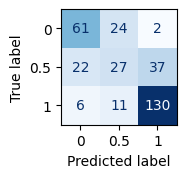

In [107]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 0.5, 1])
cm_display.plot(ax=ax, colorbar=False, cmap='Blues')

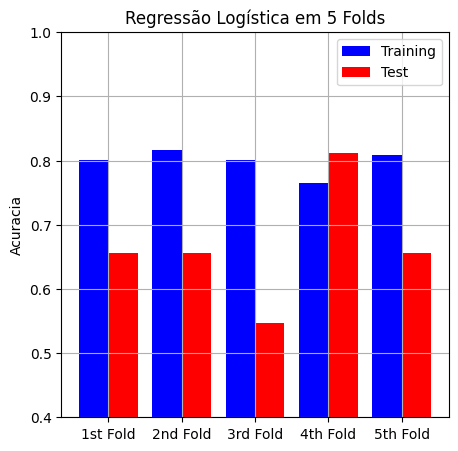

In [108]:
train_data = results['train_score']
val_data = results['test_score']
plot_title = "Regressão Logística em 5 Folds"
y_label = "Acuracia"

plt.figure(figsize=(5,5))
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
ax = plt.gca()
plt.ylim(0.40000, 1)
plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Test')
plt.title(plot_title, fontsize=12)
plt.xticks(X_axis, labels)
plt.ylabel(y_label, fontsize=10)
plt.legend()
plt.grid(True)
plt.show()

### Modelo Árvore de Decisão

In [109]:
X, y = generate_df_feature_label(data)

In [110]:
list_scores = []
min_vals = np.linspace(0.001, 1, num = 500)

for min_val in min_vals:

   model = DecisionTreeClassifier(min_samples_split = min_val)
   scores = cross_val_score(model, X, y, cv = kfold, scoring='accuracy')

   list_scores.append({'min_sample': min_val, 'accuracy': scores.mean(), 'std': scores.std()})

max_accuracy = max([x['accuracy'] for x in list_scores])
min_sample = [x['min_sample'] for x in list_scores if x['accuracy'] == max_accuracy][0]
desvio = [x['std'] for x in list_scores if x['accuracy'] == max_accuracy][0]

print('Acurácia: {:.2f} +/- {:.3f}, min_sample: {}'.format(max_accuracy, desvio, min_sample))

Acurácia: 0.62 +/- 0.081, min_sample: 0.313312625250501


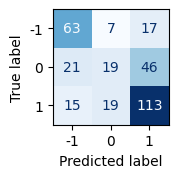

In [111]:
model_decision_tree = DecisionTreeClassifier(min_samples_split=min_sample)
model_decision_tree_score = cross_val_score(model_decision_tree, X, y, cv=kfold, scoring='accuracy')
y_pred = cross_val_predict(model_decision_tree, X, y, cv=5)


fig, ax = plt.subplots(figsize=(1.5,1.5))
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
cm_display.plot(ax=ax, colorbar=False, cmap='Blues')

### Modelo Random Forest

In [112]:
X, y = generate_df_feature_label(data)

In [113]:
list_scores = []
min_vals = np.linspace(0.001, 1, num = 10)
nTrees = np.arange(1,1000, step=200)

for min_val in min_vals:
   for nTree in nTrees:

    model = RandomForestClassifier(min_samples_split = min_val, n_estimators = nTree)
    scores = cross_val_score(model, X, y, cv = kfold, scoring='accuracy')

    list_scores.append({'min_sample': min_val, 'nTrees': nTree, 'accuracy': scores.mean(), 'std': scores.std()})

max_accuracy = max([x['accuracy'] for x in list_scores])
min_sample = [x['min_sample'] for x in list_scores if x['accuracy'] == max_accuracy][0]
nTrees = [x['nTrees'] for x in list_scores if x['accuracy'] == max_accuracy][0]
desvio = [x['std'] for x in list_scores if x['accuracy'] == max_accuracy][0]

print('Acurácia: {:.2f} +/- {:.3f}, min_sample: {}, nTrees: {}'.format(max_accuracy, desvio, min_sample, nTrees))

Acurácia: 0.64 +/- 0.025, min_sample: 0.001, nTrees: 601


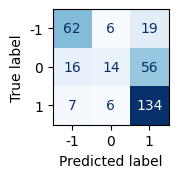

In [114]:
model_random_forest = RandomForestClassifier(min_samples_split=min_sample, n_estimators=nTrees)
model_random_forest_score = cross_val_score(model_random_forest, X, y, cv=kfold, scoring='accuracy')
y_pred = cross_val_predict(model_random_forest, X, y, cv=5)


fig, ax = plt.subplots(figsize=(1.5,1.5))
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
cm_display.plot(ax=ax, colorbar=False, cmap='Blues')

### Comparando Resultados

In [116]:
{
    'LogisticRegression' : '{:.2f} +/- {:.3f}'.format(model_log_reg_score.mean(), model_log_reg_score.std()),
    'DecisionTree' : '{:.2f} +/- {:.3f}'.format(model_decision_tree_score.mean(), model_decision_tree_score.std()),
    'RandomForest' : '{:.2f} +/- {:.3f}'.format(model_random_forest_score.mean(), model_random_forest_score.std())
}

{'LogisticRegression': '0.66 +/- 0.064',
 'DecisionTree': '0.60 +/- 0.050',
 'RandomForest': '0.64 +/- 0.053'}

### Gerando Modelo

In [128]:
X, y = generate_df_feature_label(data, normalize=True)

In [136]:
model_log_reg = LogisticRegression(C=c_param)
for train_index, test_index in kfold.split(X):
   X_train, X_test = X.iloc[train_index], X.iloc[test_index]
   y_train, y_test = y.iloc[train_index], y.iloc[test_index]

   model_log_reg.fit(X_train, y_train) 
   y_pred = model_log_reg.predict(X_test)
   scores = model_log_reg.score(X_test, y_test)
   print('accuracy: {:.2f}'.format(scores.mean()))

accuracy: 0.69
accuracy: 0.67
accuracy: 0.62
accuracy: 0.66
accuracy: 0.80


In [142]:
dump(model_log_reg, f'modelos/modelo_regressao_logistica_brasileirao_{season}.joblib')

['modelos/modelo_regressao_logistica_brasileirao_2023.joblib']

### Avaliando Resultados em toda base

In [147]:
df_previsao = pd.read_excel('data/trusted/base_brasileirao_2023.xlsx')
df_previsao = df_previsao.dropna()

In [148]:
X, y = generate_df_feature_label(df_previsao, True)

In [149]:
model_log_reg.fit(X, y) 
y_pred = model_log_reg.predict(X)
scores = model_log_reg.score(X, y)
print('accuracy: {:.2f}'.format(scores.mean()))

accuracy: 0.81


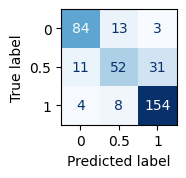

In [150]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 0.5, 1])
cm_display.plot(ax=ax, colorbar=False, cmap='Blues')